## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.


In [4]:
import pandas as pd

df = pd.read_csv(r"C:\Users\BOSCO\Desktop\Ironhack\Week_2\Day_5\Lab\lab-eda-bivariate\amz_uk_price_prediction_dataset.csv")


In [ ]:
# 1. Crosstab Analysis

# We Create a crosstab to count how many products are or aren't best sellers per category

crosstab = pd.crosstab(df['category'], df['isBestSeller'])
# ^ pd.crosstab() builds a *contingency table* that shows how two categorical variables relate.
#   In this case:
#   - Rows represent each unique product category in df['category']
#   - Columns represent each possible value of df['isBestSeller'] (e.g., True/False or 1/0)
#   - Each cell in the resulting table shows how many products belong to that combination.
#   Example: the cell at ('Electronics', True) counts how many Electronics products are best-sellers.

print(crosstab)
# ^ This prints a table where each row is a product category and each column is a best-seller status.
#   You can visually compare how many best-sellers exist per category.


# We now calculate the proportion of best-sellers within each category

crosstab_prop = crosstab.div(crosstab.sum(axis=1), axis=0)
# ^ The .div() method divides one DataFrame by another.
#   - Here we divide every value in each row of 'crosstab' by the total count of that same row.
#   - crosstab.sum(axis=1) computes the *sum across columns* (axis=1) for each row (i.e., total products in that category).
#   - axis=0 inside .div() means: "perform division row by row" (broadcast the totals vertically).
#   As a result, each row now shows proportions instead of counts (so each row sums up to 1.0).


# Now we sort the categories by the proportion of best-sellers in descending order

sorted_prop = crosstab_prop.sort_values(by=True, ascending=False)
# ^ .sort_values() sorts the DataFrame by a chosen column.
#   - by=True means we sort by the column labeled True (i.e., the share of products that *are* best-sellers).
#   - ascending=False puts the highest proportions first.
#   If your column uses 1/0 instead of True/False, replace True with 1.
#   This sorting allows us to quickly identify which categories have the *highest share* of best-sellers.

print(sorted_prop)
# ^ This shows the proportion of best-sellers in each category, ordered from most to least.
#   You can interpret this to answer:
#   “Are there categories where being a best-seller is more prevalent?”
#   The top rows will represent those categories.



isBestSeller                    False  True 
category                                    
3D Printers                       247      1
3D Printing & Scanning           4065      2
Abrasive & Finishing Products     245      5
Action Cameras                   1696      1
Adapters                          251      3
...                               ...    ...
Wind Instruments                  243      7
Window Treatments                 234      5
Women                           17559    213
Women's Sports & Outdoor Shoes   1939     20
eBook Readers & Accessories       246      0

[296 rows x 2 columns]
isBestSeller                       False     True 
category                                          
Grocery                         0.941865  0.058135
Smart Home Security & Lighting  0.942308  0.057692
Health & Personal Care          0.942314  0.057686
Mobile Phone Accessories        0.957529  0.042471
Power & Hand Tools              0.964661  0.035339
...                               

**Interpretation:**

The crosstab analysis reveals that the proportion of best-seller products varies significantly by category. Most categories show fewer than 6 % of products marked as best-sellers, highlighting how selective this status is. Categories such as Women’s Fashion and Grocery demonstrate higher relative shares, suggesting that high-volume, consumer-oriented categories are more likely to contain best-sellers. Conversely, highly specialized categories such as CPUs or eBook Readers show no best-sellers at all, indicating niche or low-rotation product lines.

In [10]:
# 2.1 STATISTICAL TESTS - Chi-Square test

from scipy.stats import chi2_contingency
# ^ chi2_contingency() performs the Chi-square test of independence on a contingency table.

# Perform the Chi-square test using our crosstab table from Step 1
chi2, p, dof, expected = chi2_contingency(crosstab)
# ^ Parameters:
#     crosstab : the observed frequency table (counts per category × best-seller)
# ^ Returns:
#     chi2     : the computed Chi-square statistic
#     p        : the p-value — tells us if the result is statistically significant
#     dof      : degrees of freedom (used internally for the Chi-square distribution)
#     expected : the expected counts if category and best-seller were independent
#   → In simple terms, it compares what we *observe* to what we *would expect*
#     if category and best-seller were unrelated.

# Display the key test outputs
print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.6f}")
# ^ .4f / .6f just format the numbers to 4 or 6 decimals for readability.

# INTERPRETATION:
# If p < 0.05 → reject independence → best-seller distribution depends on category.
# If p ≥ 0.05 → fail to reject → best-seller status appears independent of category.




Chi-square statistic: 36540.2027
Degrees of freedom: 295
P-value: 0.000000


**Interpretation:**

The Chi-square test shows a p-value near 0, meaning it’s extremely unlikely that the observed pattern happened by chance.
This tells us that product category and best-seller status are statistically related — in other words, whether a product becomes a best-seller depends on its category.

In [9]:
# 2.2 STATISTICAL TESTS - CRAMÉR'S V (measure of association strength)

import numpy as np
# ^ We'll use numpy for mathematical operations like square roots.

# Formula: V = sqrt(χ² / (n * (k - 1)))
# where:
#   χ² = Chi-square statistic
#   n  = total sample size (sum of all counts)
#   k  = smaller dimension between (rows, columns)
n = crosstab.sum().sum()           # Total number of observations (all products)
min_dim = min(crosstab.shape) - 1  # Smaller dimension minus 1 (rows or columns)
cramers_v = np.sqrt(chi2 / (n * min_dim))
# ^ This computes the strength of the association between category and best-seller status.
#   The closer cramers_v is to 1 → stronger association.
#   Around 0 → little or no relationship.

print(f"Cramér's V: {cramers_v:.4f}")
# Example interpretation:
#   0.00–0.10 → very weak
#   0.10–0.30 → weak
#   0.30–0.50 → moderate
#   >0.50     → strong
    

Cramér's V: 0.1223


**Interpretation:**

Cramér’s V (0.1223) indicates a weak but significant association between product category and best-seller status, suggesting that while category has some influence, other product characteristics likely contribute more strongly to best-seller performance.

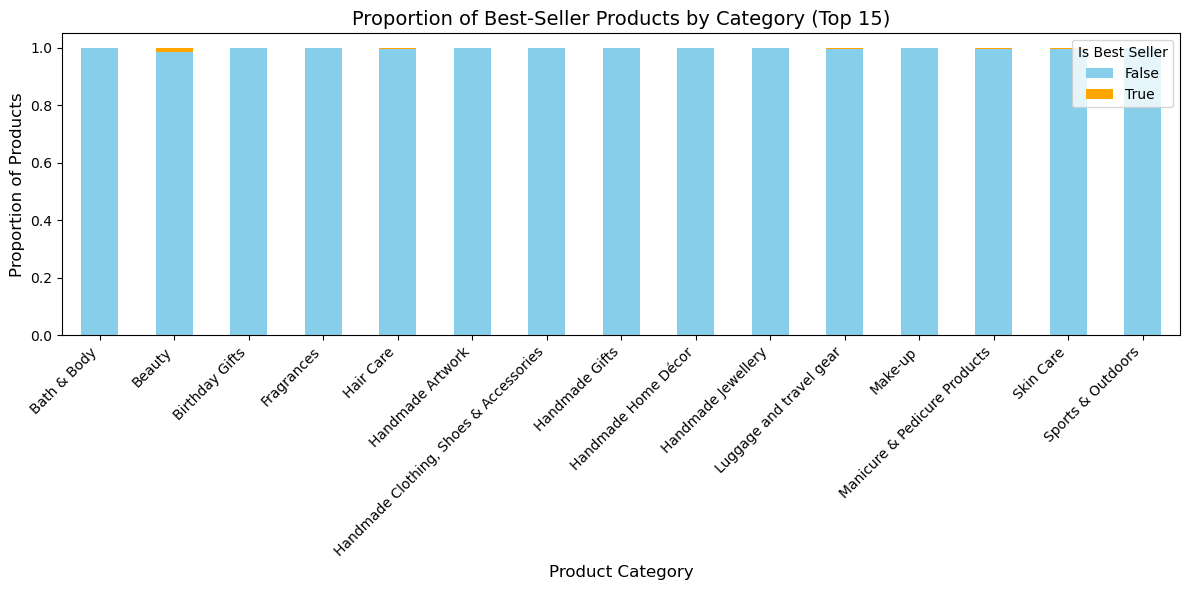

In [13]:
# 3. VISUALIZATION (STACKED BAR CHART) 

import matplotlib.pyplot as plt      # for basic plotting
import seaborn as sns                # for more aesthetic charts

# To keep the chart readable, we will focus on the top 15 categories with most products
top_categories = df['category'].value_counts().head(15).index
# ^ value_counts() counts how many products exist per category
# ^ head(15) limits to the 15 largest categories by number of products
# ^ .index extracts just their names

df_top = df[df['category'].isin(top_categories)]
# ^ Filters the original dataset to include only those top 15 categories

# Now we create a crosstab to count True/False best-sellers in each of those categories
crosstab_top = pd.crosstab(df_top['category'], df_top['isBestSeller'])
# ^ Rows = categories, columns = bestseller status (True/False)

# This converts counts to percentages for better visual comparison
crosstab_top_prop = crosstab_top.div(crosstab_top.sum(axis=1), axis=0)
# ^ Divides each row by its row total so bars are proportional (sum = 1)

# We now create a stacked bar plot
crosstab_top_prop.plot(
    kind='bar',                      # bar chart type
    stacked=True,                    # bars stacked (False + True segments)
    figsize=(12, 6),                 # size in inches (width, height)
    color=['skyblue', 'orange']      # optional: colors for False/True
)
# ^ Each bar represents one category
#   The orange portion shows the share of best-sellers
#   The blue portion shows the share of non-best-sellers

plt.title('Proportion of Best-Seller Products by Category (Top 15)', fontsize=14)
# ^ Adds a descriptive title

plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Proportion of Products', fontsize=12)
plt.xticks(rotation=45, ha='right')  # rotate category names for readability
plt.legend(title='Is Best Seller', loc='upper right')
plt.tight_layout()                    # ensure labels fit within the figure
plt.show()
